In [3]:
# Import necessary libraries
import time
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import matplotlib.pyplot as plt
import scipy.optimize as spo
import scipy.stats as sps

%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


# Gaussian processes

Let us implement a simple Gaussian process class, with sampling. We consider three kernels: squared exponential (or "RBF"), Matern, and periodic. 

In [4]:
class GP:
    
    def __init__(self, kernelName, logHyp):  
        """
        Initializes class
        """
        self.kernelName = kernelName
        self.logHyp = logHyp        
        
    def kernel(self, x, y, logHyp):
        """ 
        choose between 1D squared exponential kernel, Matern kernel, and periodic kernel
        """
        hyp = np.exp(logHyp)
        r = np.abs(x-y)
        if self.kernelName == "se":
            return hyp[0] * np.exp( -.5*r**2/hyp[1]**2 ) 
        elif self.kernelName == "matern":
            return hyp[0] * ( 1+np.sqrt(3)*r/hyp[1] )*( np.exp( -np.sqrt(3)*r/hyp[1]) ) 
        elif self.kernelName == "periodic":  
            return hyp[0] * np.exp( -2*np.sin(r)**2/hyp[1]**2)

    def sampleFromZeroMeanGP(self):
        """
        sample from a zero-mean GP to show the influence of the logHypers
        it's merely sampling multivariate Gaussians!
        """
        NPlot = 200
        XPlot = np.linspace(0,10,NPlot)
        plt.xlim([0,10])
        plt.ylim([-3,3])
        K = np.array([self.kernel(XPlot[i],XPlot[j],self.logHyp) for i in range(NPlot) for j in range(NPlot)]).reshape((NPlot,NPlot)) + 1e-10*np.eye(NPlot)
        L = npl.cholesky(K)
        styles = ['-', '--', '-.']
        for i in range(3):
            YPlot = np.dot(L, npr.randn(NPlot))
            plt.plot(XPlot, YPlot, linestyle=styles[i], linewidth=3)
        plt.show()

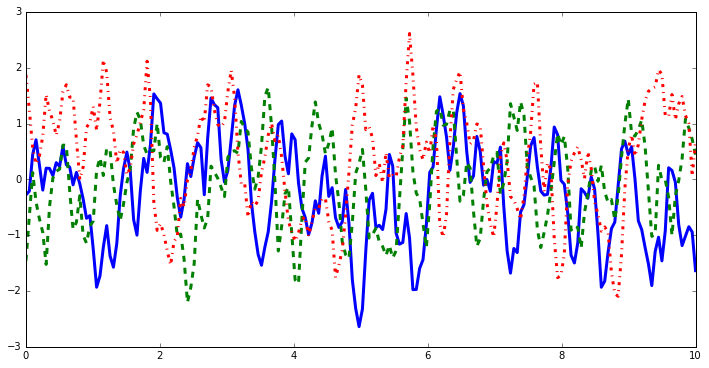

In [12]:
# illustrate draws from GP(0,k)
loga = 0
logEll = -2
gp = GP("matern", np.array([loga,logEll,0]))
gp.sampleFromZeroMeanGP()
#plt.savefig("drawsFromGP_logEll_"+str(logEll)+".pdf")

# Bayesian optimization

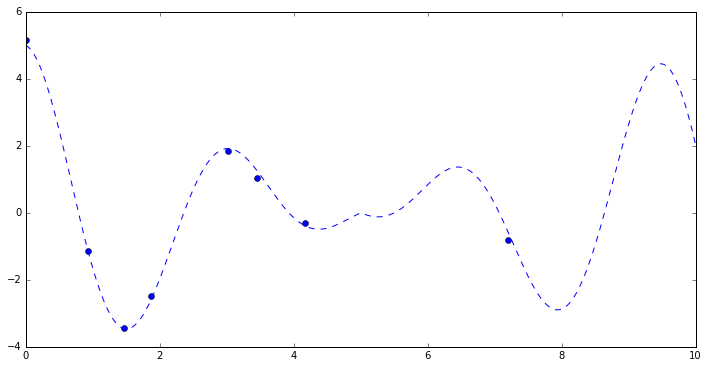

In [9]:
npr.seed(1)

# Fix a target
target = lambda x: np.abs(x-5)*np.cos(2*x)
#target = lambda x: -np.log(np.abs(x-5))*np.cos(2*x)
noise = .1

# Generate some training data
#N = 3 # with first target, demos influence of noise
N = 8 # with first target, demos exploration/exploitation tradeoff
XTrain = 10*npr.rand(N)
YTrain = target(XTrain) + noise*npr.randn(N)

# Plot training data and target
plt.figure(1)
xPlot = np.linspace(0,10,1000)
plt.plot(XTrain, YTrain, 'o')
plt.plot(xPlot, target(xPlot), '--', color='b')
plt.show()

In [10]:
# Main class implementing the steps of the SMBO loop

class BayesOptim:
    
    def __init__(self, X, Y, logHyp):  
        """
        Initializes class
        """
        self.XTrain = X.copy()
        self.NTrain = np.max(XTrain.shape)
        self.YTrainOriginal = Y.copy()
        if Y.size>0:
            self.offset = np.mean(self.YTrainOriginal)
            self.YTrain = self.YTrainOriginal - self.offset
            self.currentArgMin = np.argmin(target(self.XTrain)) 
            self.currentMin = np.min(target(self.XTrain)) 
        else: 
            print "No input data"
        self.NTest = 1000
        self.XTest = np.linspace(0, 10, self.NTest)
        
        self.logHyp = logHyp
        
        
    def kernel(self, x, y, logHyp):
        """ 
        1D squared exponential kernel, Matern kernel, and periodic kernels
        """
        hyp = np.exp(logHyp)
        return hyp[0]*np.exp( -.5*np.sum((x-y)**2)/hyp[1]**2 ) 

    def computeAndCholeskyGramMatrix(self, logHyp):
        """
        computes and stores the Cholesky decomposition of the Gram matrix
        """
        X = self.XTrain.copy()
        N = self.NTrain
        sigma = np.exp(logHyp[2])
        K = np.array([self.kernel(X[i],X[j],logHyp) for i in range(N) for j in range(N)]).reshape((N,N)) + sigma**2*np.eye(N)
        self.L = npl.cholesky(K)
        
    def negMarginalLogLhd(self, logHyp):
        """
        minus the marginal log likelihood, plus a prior term on the noise level sigma
        """
        self.computeAndCholeskyGramMatrix(logHyp)
        self.alpha = npl.solve(self.L.T, npl.solve(self.L, self.YTrain.T))
        logSigma = logHyp[2]
        return .5*np.dot(self.YTrain, self.alpha) + np.sum(np.log(np.diag(self.L))) + (logSigma)**2
        
    def tuneGP(self):
        """
        maximizes the marginal log likelihood
        """
        currentLogHyp = self.logHyp.copy()
        res = spo.fmin(lambda lh: self.negMarginalLogLhd(lh), currentLogHyp) # start at the previous value of logHyp
        self.logHyp = res   
        print "best hypers are", np.exp(res)
        self.computeAndCholeskyGramMatrix(res)
        self.alpha = npl.solve(self.L.T, npl.solve(self.L, self.YTrain.T))
        
    def computeGPMeanAndStd(self):
        """
        implements the GP prediction equations
        """
        kTest = np.array([self.kernel(self.XTest[i], self.XTrain[j], self.logHyp) for i in range(self.NTest) for j in range(self.NTrain)]).reshape((self.NTest, self.NTrain)) 
        self.gpMean = np.dot(kTest, self.alpha)
        if np.any(np.array([self.kernel(self.XTest[i], self.XTest[i], self.logHyp) - np.sum(npl.solve(self.L, kTest[i,:])**2) for i in range(self.NTest)])<0):
            print np.min(np.array([self.kernel(self.XTest[i], self.XTest[i], self.logHyp) - np.sum(npl.solve(self.L, kTest[i,:])**2) for i in range(self.NTest)]))
        self.gpStd = np.sqrt(np.array([self.kernel(self.XTest[i], self.XTest[i], self.logHyp) - np.sum(npl.solve(self.L, kTest[i,:])**2) for i in range(self.NTest)])) 
        
    def predict(self):
        """
        computes and plots predictions
        """
        plt.xlim([0,10])
        plt.ylim([np.min(self.YTrainOriginal)-5, np.max(self.YTrainOriginal)+5])
        plt.grid(True)
        plt.plot(self.XTest, target(self.XTest), '--', color='blue', linewidth=2)
        self.computeGPMeanAndStd()
        plt.ylabel("target", fontsize = 18)
        plt.plot(self.XTest, self.offset + self.gpMean, color='green', linewidth=2)
        plt.fill_between(self.XTest, self.offset + self.gpMean - self.gpStd, self.offset + self.gpMean + self.gpStd, facecolor='green', alpha = .1, interpolate=True)
        plt.plot(self.XTrain[:-1], self.offset + self.YTrain[:-1], 'o', markersize=12, markerfacecolor='none', markeredgewidth=3, markeredgecolor='blue')
        plt.plot(self.XTrain[-1], self.offset + self.YTrain[-1], 'o', markersize=12, markerfacecolor='none', markeredgewidth=3, markeredgecolor='red')
        
    def maximizeEI(self):
        """
        maximizes the expected improvement by exhaustive evaluation on a grid
        """
        m = self.currentMin
        u = (m - self.gpMean)/self.gpStd
        self.EI = self.gpStd * (u*sps.norm.cdf(u) + sps.norm.pdf(u))
        plt.xlim([0,10])
        plt.grid(True)
        plt.ylabel("EI", fontsize = 18)
        plt.plot(self.XTest, self.EI, 'r', linewidth=2)
        xStar = self.XTest[np.argmax(self.EI)]
        eiStar = np.max(self.EI)
        plt.vlines(xStar, 0, eiStar,linestyles='dashed', colors='r',linewidth=2)
        fStar = target(xStar)
        if fStar < self.currentMin:
            self.currentMin = fStar
        self.XTrain = np.concatenate((self.XTrain, np.array(xStar).reshape((1,))))
        self.YTrain = np.concatenate((self.YTrain, np.array(fStar).reshape((1,))))
        self.NTrain +=1
       
    def sampleFromZeroMeanGP(self):
        """
        sample from a zero-mean GP to show the influence of the logHypers
        this function is not used in the SMBO loop
        """
        NPlot = 200
        XPlot = np.linspace(0,10,NPlot)
        plt.xlim([0,10])
        plt.ylim([-3,3])
        K = np.array([self.kernel(XPlot[i],XPlot[j],self.logHyp) for i in range(NPlot) for j in range(NPlot)]).reshape((NPlot,NPlot)) + 1e-10*np.eye(NPlot)
        L = npl.cholesky(K)
        styles = ['-', '--', '-.']
        for i in range(3):
            plt.subplot(121)
            YPlot = np.dot(L, npr.randn(NPlot))
            plt.plot(XPlot, YPlot, linestyle=styles[i], linewidth=3)
            plt.subplot(122)
            plt.hist(YPlot, alpha=.3)
        plt.show()

Iteration 0
Optimization terminated successfully.
         Current function value: 9.606023
         Iterations: 171
         Function evaluations: 312
best hypers are [ 7.69053398  0.78960108  0.58213136]


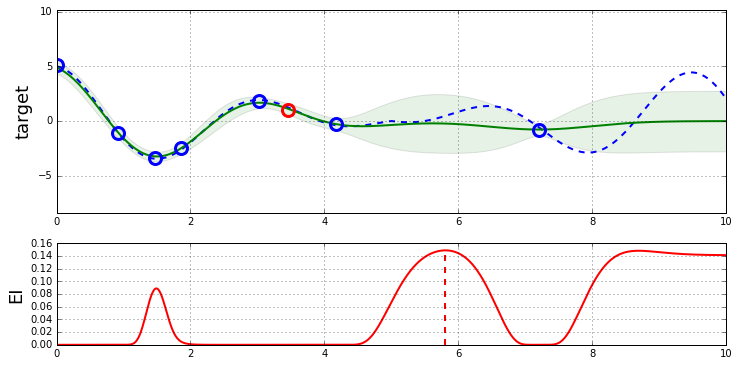

Iteration 1
Optimization terminated successfully.
         Current function value: 10.603290
         Iterations: 54
         Function evaluations: 99
best hypers are [ 6.19876506  0.73878935  0.59700844]


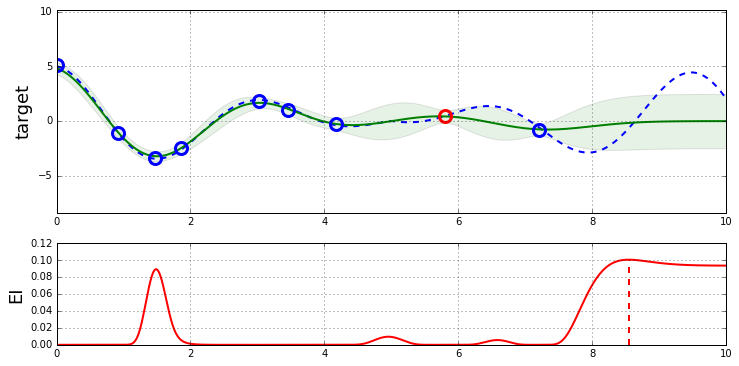

Iteration 2
Optimization terminated successfully.
         Current function value: 11.508855
         Iterations: 46
         Function evaluations: 86
best hypers are [ 5.21762242  0.7029021   0.60731845]


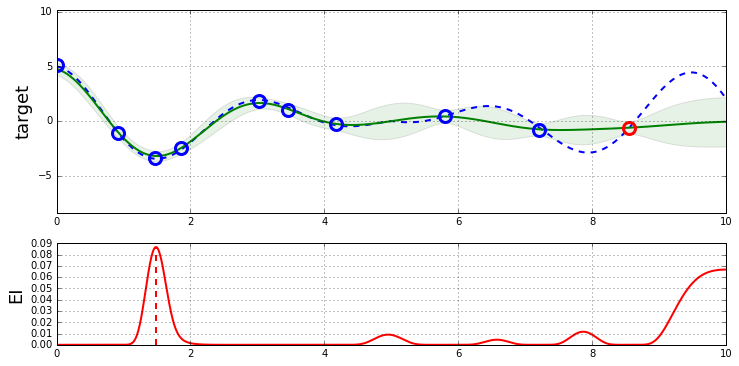

Iteration 3
Optimization terminated successfully.
         Current function value: 11.106458
         Iterations: 54
         Function evaluations: 96
best hypers are [ 5.90487634  0.77154179  0.40776752]


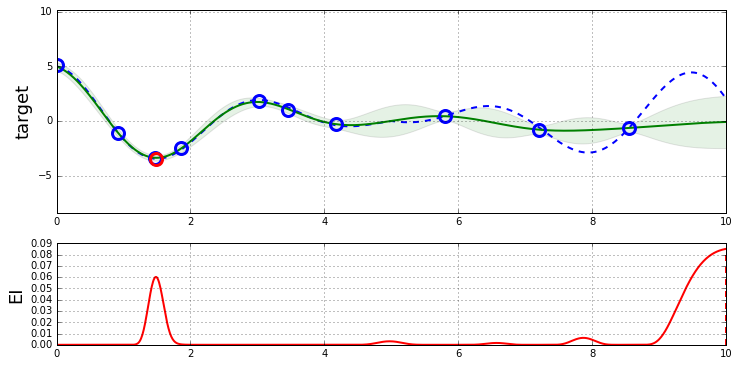

Iteration 4
Optimization terminated successfully.
         Current function value: 12.371058
         Iterations: 39
         Function evaluations: 74
best hypers are [ 5.62885646  0.75659909  0.41201334]


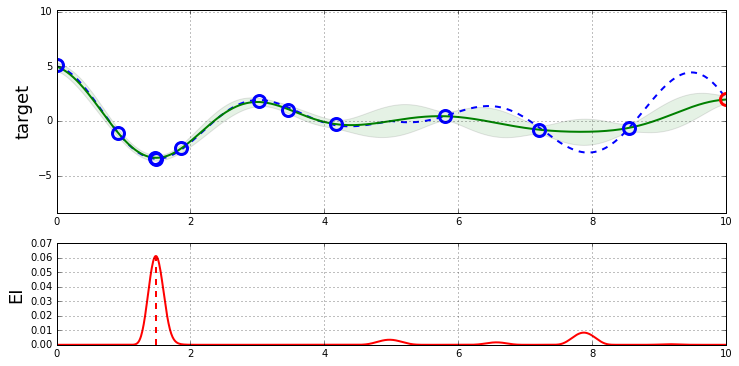

Iteration 5
Optimization terminated successfully.
         Current function value: 11.479412
         Iterations: 63
         Function evaluations: 118
best hypers are [ 6.06998093  0.80463753  0.27849022]


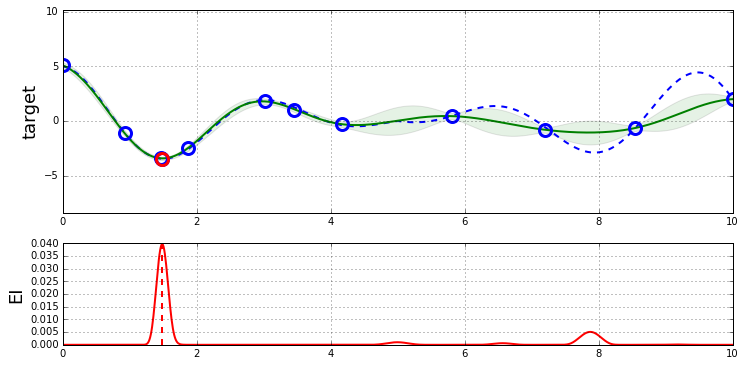

Iteration 6
Optimization terminated successfully.
         Current function value: 10.148454
         Iterations: 55
         Function evaluations: 96
best hypers are [ 6.37386208  0.83657621  0.18849498]


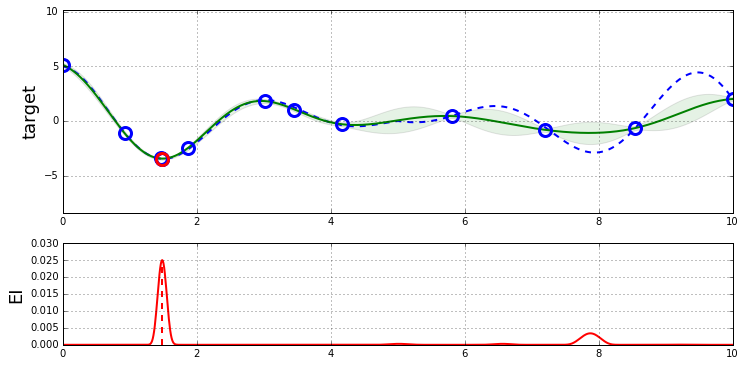

Iteration 7
Optimization terminated successfully.
         Current function value: 8.398063
         Iterations: 49
         Function evaluations: 92
best hypers are [ 6.56612804  0.85638037  0.12736966]


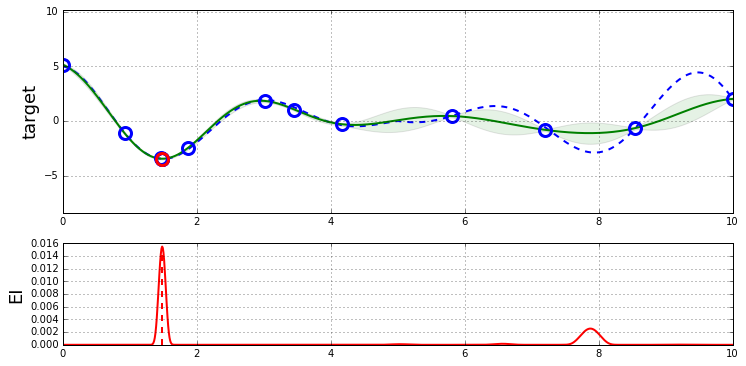

Iteration 8
Optimization terminated successfully.
         Current function value: 6.240197
         Iterations: 61
         Function evaluations: 111
best hypers are [ 6.67490821  0.86745735  0.08683375]


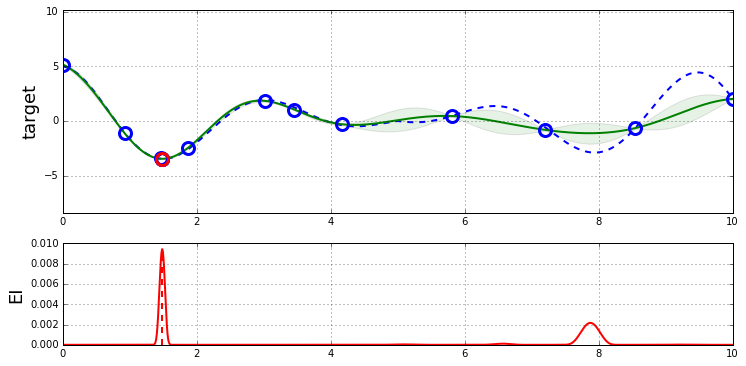

Iteration 9
Optimization terminated successfully.
         Current function value: 3.702200
         Iterations: 44
         Function evaluations: 83
best hypers are [ 6.73193103  0.87309534  0.0613497 ]


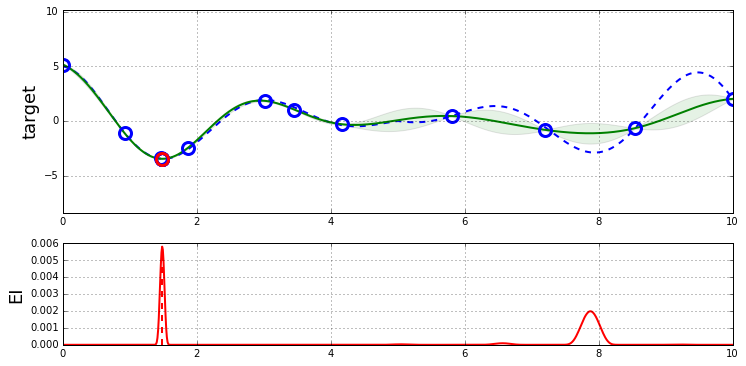

In [40]:
# SMBO loop
bo = BayesOptim(XTrain, YTrain, np.zeros((3,), float))

for i in range(10):
    print "Iteration", i
    
    plt.figure(1)
    gs = plt.GridSpec(2, 1, height_ratios=[2, 1]) 

    # Tune hypers
    bo.tuneGP()

    # Plot predictive distributions
    plt.subplot(gs[0])
    bo.predict()

    # Maximize expected improvement
    plt.subplot(gs[1])
    bo.maximizeEI()
    
    #plt.savefig("Figures/example_step_"+str(i)+".pdf")
    plt.show()